In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!pip install rasterio

In [41]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = "/content/drive/MyDrive/data-20250917T044725Z-1-001.zip"

# Path where the contents will be extracted
extract_path = "/content/drive/MyDrive/WaterSegmentation"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed at:", extract_path)
print("Contents:", os.listdir(extract_path))


Extraction completed at: /content/drive/MyDrive/WaterSegmentation
Contents: ['data']


In [57]:
#Load TIFF images
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.io import imsave

In [43]:
#Define dataset paths
DATASET_PATH = "/content/drive/MyDrive/WaterSegmentation"
TRAIN_PATH = f"{DATASET_PATH}/data/images"
LABEL_PATH = f"{DATASET_PATH}/data/labels"

In [44]:
# Example: load one image from the train folder
sample_image_path = os.path.join(TRAIN_PATH, os.listdir(TRAIN_PATH)[0])
sample_mask_path = os.path.join(LABEL_PATH, os.listdir(LABEL_PATH)[0])

with rasterio.open(sample_image_path) as src:
    img = src.read()  # (bands, height, width)
    profile = src.profile

with rasterio.open(sample_mask_path) as msk_src:
    mask = msk_src.read(1)  # mask is usually a single channel

print("Image shape:", img.shape)   # (bands, H, W)
print("Mask shape:", mask.shape)   # (H, W)

Image shape: (12, 128, 128)
Mask shape: (128, 128)


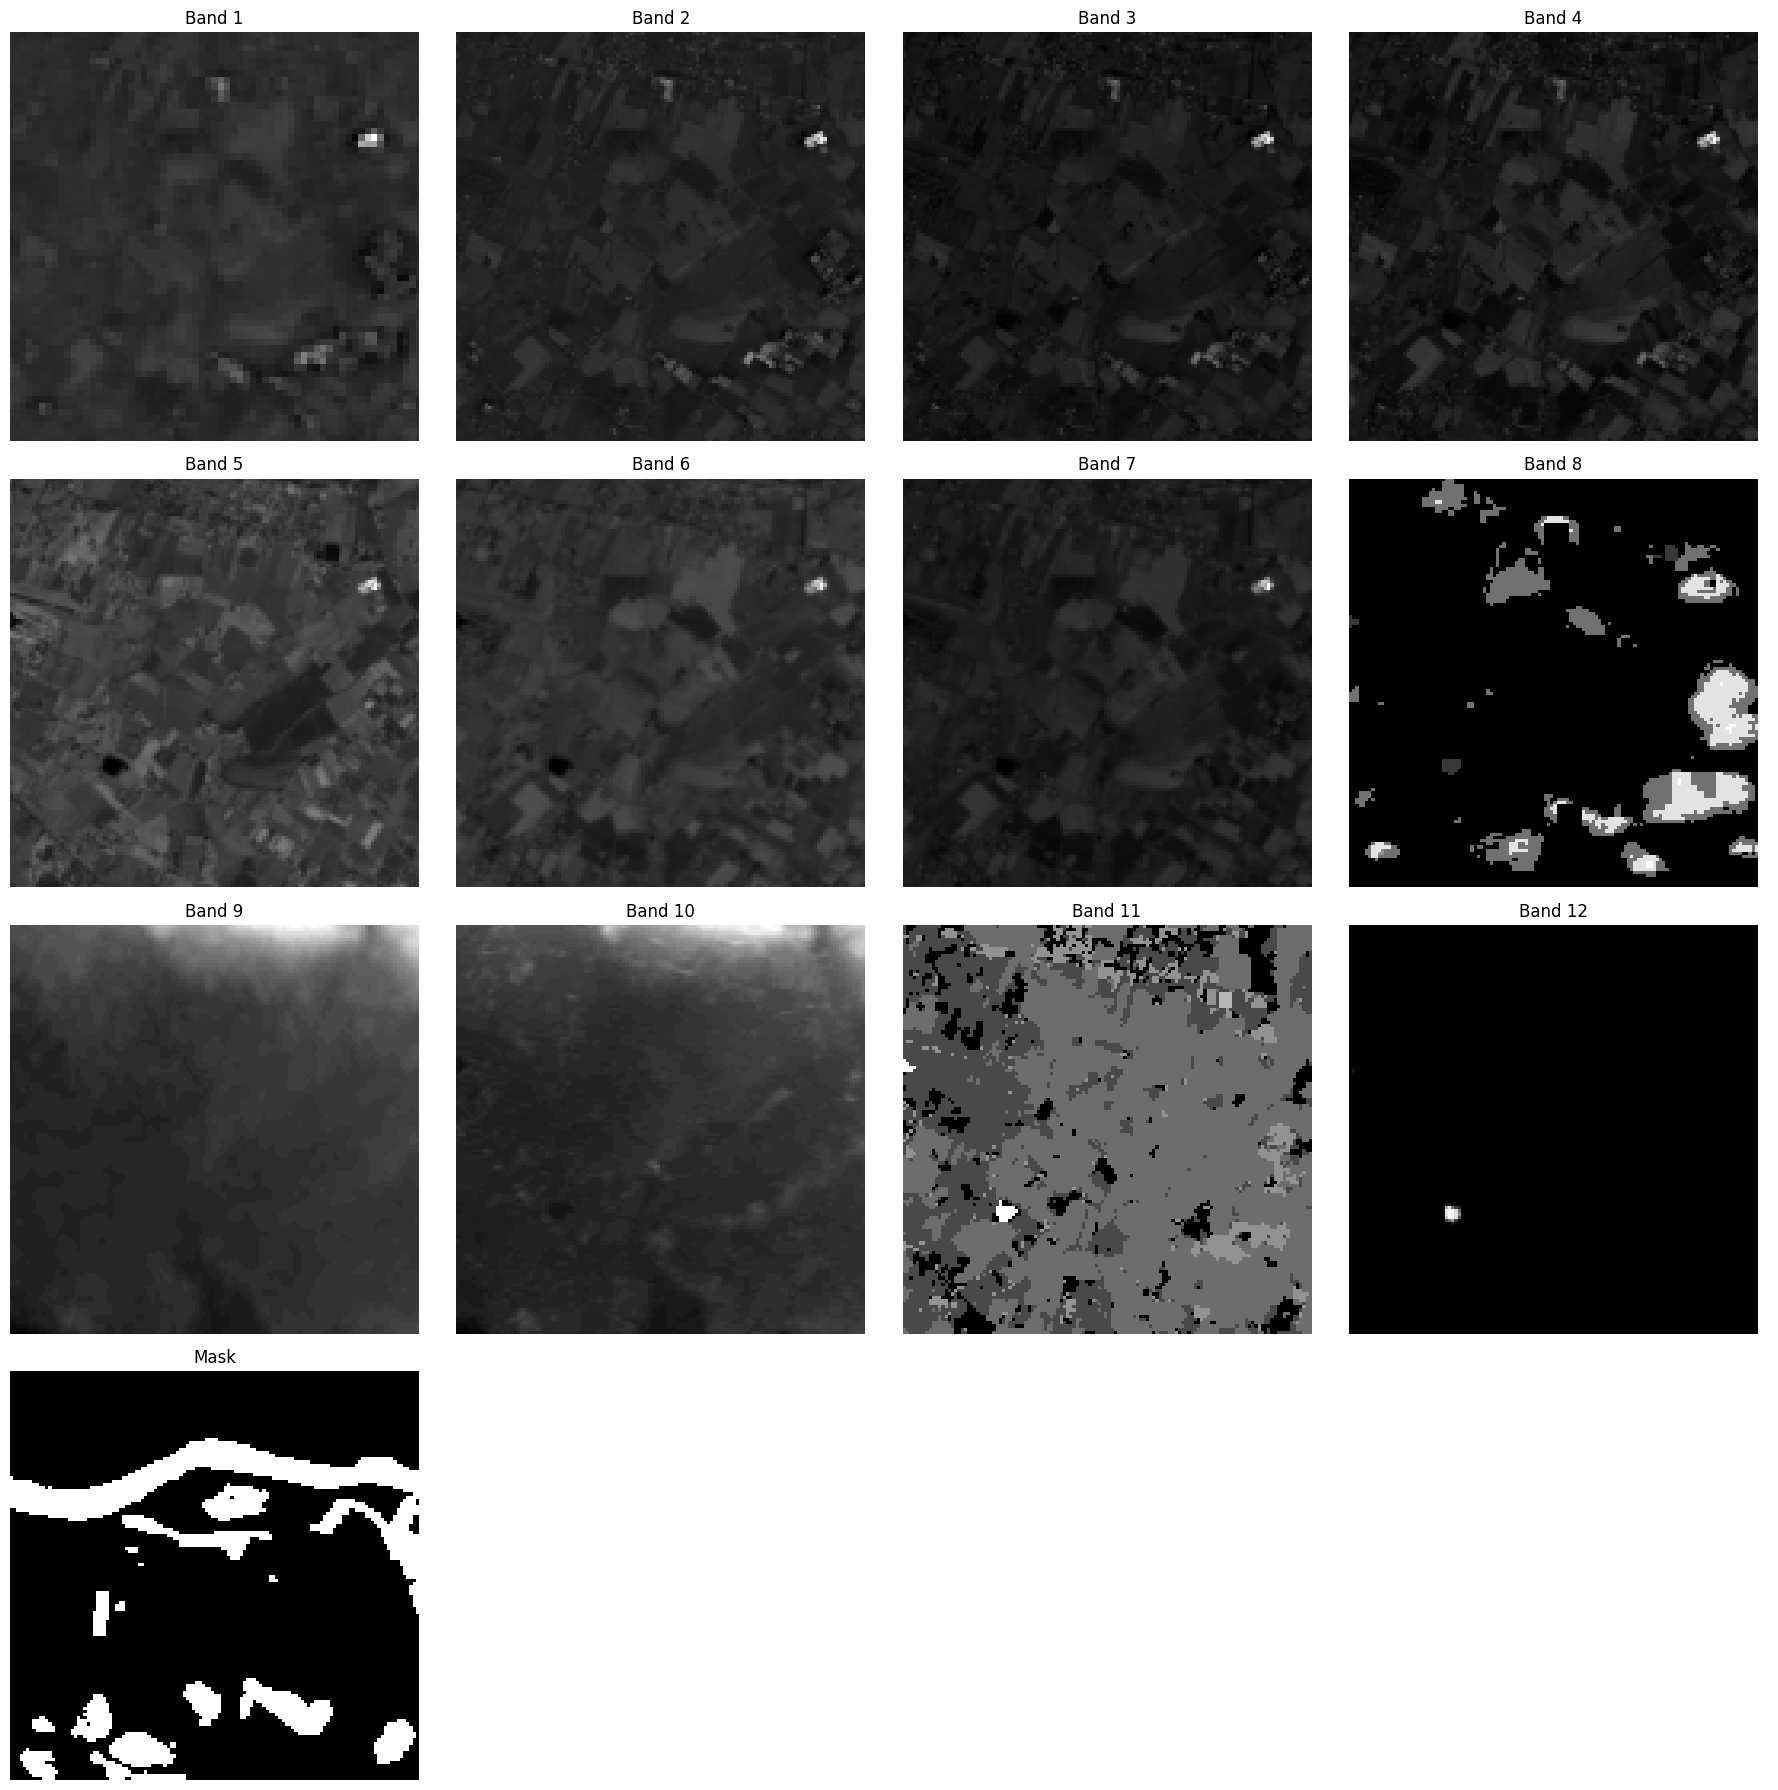

In [ ]:
import matplotlib.pyplot as plt

# total = 12 bands + 1 mask = 13
fig, axes = plt.subplots(4, 4, figsize=(18, 18))

# flatten axes for easy indexing
axes = axes.flatten()

# Plot 12 bands
for i in range(img.shape[0]):
    axes[i].imshow(img[i], cmap="gray")
    axes[i].set_title(f"Band {i+1}")
    axes[i].axis("off")

# Mask
axes[12].imshow(mask, cmap="gray")
axes[12].set_title("Mask")
axes[12].axis("off")

# Hide unused subplots (if any)
for j in range(13, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [46]:
import os

train_images = os.listdir(TRAIN_PATH)
train_masks = os.listdir(LABEL_PATH)

print("Number of images:", len(train_images))
print("Number of masks:", len(train_masks))


Number of images: 306
Number of masks: 456


In [ ]:
import os

image_files = sorted(os.listdir(TRAIN_PATH))  # ['0.tif', '1.tif', ...]
mask_files = sorted(os.listdir(LABEL_PATH))   # ['1.png', '2.png', ...]

# Match mask names to image names (assuming masks correspond to images with +1 index)
matched_images = []
matched_masks = []

for img_file in image_files:
    img_idx = int(img_file.split(".")[0]) # Extract number from image filename
    mask_file = f"{img_idx}.png"  # Try to find the same number
    if mask_file in mask_files:
        matched_images.append(img_file)
        matched_masks.append(mask_file)

print("Matched samples:", len(matched_images), len(matched_masks))


Matched samples: 306 306


In [48]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    matched_images, matched_masks, test_size=0.2, random_state=42
)

print("Train samples:", len(train_imgs))
print("Validation samples:", len(val_imgs))


Train samples: 244
Validation samples: 62


In [49]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, image_dir, mask_dir, batch_size=8, shuffle=True):
        self.image_filenames = list(image_filenames)
        self.mask_filenames = list(mask_filenames)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        batch_masks = self.mask_filenames[index*self.batch_size:(index+1)*self.batch_size]

        if len(batch_images) == 0:
            # Safety check
            batch_images = [self.image_filenames[0]]
            batch_masks = [self.mask_filenames[0]]

        X = np.zeros((len(batch_images), 128, 128, 12), dtype=np.float32)  # channels last
        y = np.zeros((len(batch_masks), 128, 128, 1), dtype=np.float32)

        for i, (img_file, mask_file) in enumerate(zip(batch_images, batch_masks)):
            # load image
            with rasterio.open(os.path.join(self.image_dir, img_file)) as src:
                img = src.read()  # (bands, H, W)
                img_norm = np.zeros_like(img, dtype=np.float32)
                for b in range(img.shape[0]):
                    band = img[b]
                    img_norm[b] = (band - band.min()) / (band.max() - band.min() + 1e-8)
                X[i] = np.transpose(img_norm, (1,2,0))  # HWC

            # load mask
            with rasterio.open(os.path.join(self.mask_dir, mask_file)) as msk_src:
                mask = msk_src.read(1)
                y[i, ..., 0] = mask  # no extra normalization


        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)  # convert to np.array

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_filenames, self.mask_filenames))
            np.random.shuffle(temp)
            self.image_filenames, self.mask_filenames = zip(*temp)
            self.image_filenames = list(self.image_filenames)
            self.mask_filenames = list(self.mask_filenames)


In [50]:
train_gen = DataGenerator(train_imgs, train_masks, TRAIN_PATH, LABEL_PATH, batch_size=16)
val_gen = DataGenerator(val_imgs, val_masks, TRAIN_PATH, LABEL_PATH, batch_size=16)

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)

    # -------- Encoder --------
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # -------- Bottleneck --------
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # -------- Decoder --------
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model


In [52]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [53]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


In [54]:
# -------- Build & Compile --------
model = build_unet(input_shape=(128, 128, 12))
model.compile(optimizer='adam',
              loss=bce_dice_loss,
              metrics=['accuracy', iou_metric])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_57[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_61[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_63[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 8, 8, 512) │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_15… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_65[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 16, 16,    │  2,097,664 │ conv2d_66[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,         # Reduce learning rate by half
        patience=5,         # Wait for 5 epochs without improvement
        verbose=2,          # Print all changes
        min_lr=1e-7,        # Minimum learning rate
        min_delta=1e-5,     # Minimum change in val_loss to be considered significant
        mode='auto'         # Depends on the type of monitor (min or max)
    )
]

In [56]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.7101 - iou_metric: 0.4193 - loss: 1.1054

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7158 - iou_metric: 0.4244 - loss: 1.0970 - val_accuracy: 0.4209 - val_iou_metric: 0.2582 - val_loss: 2.1527 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7890 - iou_metric: 0.5288 - loss: 0.9680

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - accuracy: 0.7931 - iou_metric: 0.5321 - loss: 0.9554 - val_accuracy: 0.8965 - val_iou_metric: 0.5793 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9075 - iou_metric: 0.6047 - loss: 0.6117

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 576ms/step - accuracy: 0.9064 - iou_metric: 0.6049 - loss: 0.6123 - val_accuracy: 0.9066 - val_iou_metric: 0.6042 - val_loss: 0.5991 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8930 - iou_metric: 0.6357 - loss: 0.5850

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 685ms/step - accuracy: 0.8931 - iou_metric: 0.6351 - loss: 0.5856 - val_accuracy: 0.9108 - val_iou_metric: 0.6272 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8959 - iou_metric: 0.6307 - loss: 0.5765

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 788ms/step - accuracy: 0.8961 - iou_metric: 0.6322 - loss: 0.5753 - val_accuracy: 0.9137 - val_iou_metric: 0.6371 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8978 - iou_metric: 0.6798 - loss: 0.5298

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 604ms/step - accuracy: 0.8981 - iou_metric: 0.6777 - loss: 0.5308 - val_accuracy: 0.9176 - val_iou_metric: 0.6475 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9054 - iou_metric: 0.5884 - loss: 0.5602

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 705ms/step - accuracy: 0.9053 - iou_metric: 0.5914 - loss: 0.5580 - val_accuracy: 0.9196 - val_iou_metric: 0.6652 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 509ms/step - accuracy: 0.8923 - iou_metric: 0.6311 - loss: 0.5503 - val_accuracy: 0.9094 - val_iou_metric: 0.6547 - val_loss: 0.5298 - learning_rate: 0.0010
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - accuracy: 0.7960 - iou_metric: 0.5959 - loss: 1.0416 - val_accuracy: 0.9057 - val_iou_metric: 0.6182 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 535ms/step - accuracy: 0.8947 - iou_metric: 0.6316 - loss: 0.5552 - val_accuracy: 0.9173 - val_iou_metric: 0.6529 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - accuracy: 0.8973 - iou_metric: 0.6368 - loss: 0.5414 - val_accuracy: 0.9186 - val_iou_metric: 0.6687 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 12/100
1

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 850ms/step - accuracy: 0.9103 - iou_metric: 0.6337 - loss: 0.4918 - val_accuracy: 0.9222 - val_iou_metric: 0.6859 - val_loss: 0.4376 - learning_rate: 5.0000e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9042 - iou_metric: 0.6698 - loss: 0.4861

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - accuracy: 0.9045 - iou_metric: 0.6695 - loss: 0.4854 - val_accuracy: 0.9221 - val_iou_metric: 0.6763 - val_loss: 0.4334 - learning_rate: 5.0000e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 493ms/step - accuracy: 0.9102 - iou_metric: 0.6968 - loss: 0.4543 - val_accuracy: 0.9137 - val_iou_metric: 0.6701 - val_loss: 0.4716 - learning_rate: 5.0000e-04
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9079 - iou_metric: 0.7013 - loss: 0.4426

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 788ms/step - accuracy: 0.9079 - iou_metric: 0.7001 - loss: 0.4433 - val_accuracy: 0.9255 - val_iou_metric: 0.6828 - val_loss: 0.4245 - learning_rate: 5.0000e-04
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9012 - iou_metric: 0.6760 - loss: 0.4785

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 562ms/step - accuracy: 0.9018 - iou_metric: 0.6767 - loss: 0.4774 - val_accuracy: 0.9268 - val_iou_metric: 0.6947 - val_loss: 0.4179 - learning_rate: 5.0000e-04
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 630ms/step - accuracy: 0.9161 - iou_metric: 0.7125 - loss: 0.4290 - val_accuracy: 0.9236 - val_iou_metric: 0.7085 - val_loss: 0.4182 - learning_rate: 5.0000e-04
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9066 - iou_metric: 0.6843 - loss: 0.4682

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 587ms/step - accuracy: 0.9067 - iou_metric: 0.6854 - loss: 0.4675 - val_accuracy: 0.9269 - val_iou_metric: 0.6937 - val_loss: 0.4168 - learning_rate: 5.0000e-04
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.9182 - iou_metric: 0.7076 - loss: 0.4298 - val_accuracy: 0.9237 - val_iou_metric: 0.6717 - val_loss: 0.4444 - learning_rate: 5.0000e-04
Epoch 21/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 553ms/step - accuracy: 0.9090 - iou_metric: 0.7222 - loss: 0.4399 - val_accuracy: 0.9252 - val_iou_metric: 0.6981 - val_loss: 0.4292 - learning_rate: 5.0000e-04
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 472ms/step - accuracy: 0.9081 - iou_metric: 0.7022 - loss: 0.4540 - val_accuracy: 0.9118 - val_iou_metric: 0.6820 - val_loss: 0.4484 - learning_rate: 5.0000e-04
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9094 - iou_metric: 0.6904 - loss: 0.4457

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 785ms/step - accuracy: 0.9097 - iou_metric: 0.6907 - loss: 0.4450 - val_accuracy: 0.9279 - val_iou_metric: 0.6903 - val_loss: 0.4123 - learning_rate: 5.0000e-04
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 511ms/step - accuracy: 0.9120 - iou_metric: 0.7168 - loss: 0.4240 - val_accuracy: 0.9296 - val_iou_metric: 0.6768 - val_loss: 0.4228 - learning_rate: 5.0000e-04
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9200 - iou_metric: 0.7073 - loss: 0.4194

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 577ms/step - accuracy: 0.9196 - iou_metric: 0.7075 - loss: 0.4200 - val_accuracy: 0.9304 - val_iou_metric: 0.7128 - val_loss: 0.3888 - learning_rate: 5.0000e-04
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.9186 - iou_metric: 0.7304 - loss: 0.4145 - val_accuracy: 0.9145 - val_iou_metric: 0.6954 - val_loss: 0.4287 - learning_rate: 5.0000e-04
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.9093 - iou_metric: 0.7047 - loss: 0.4242 - val_accuracy: 0.9270 - val_iou_metric: 0.7155 - val_loss: 0.4181 - learning_rate: 5.0000e-04
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9174 - iou_metric: 0.7252 - loss: 0.4031

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 702ms/step - accuracy: 0.9174 - iou_metric: 0.7246 - loss: 0.4035 - val_accuracy: 0.9299 - val_iou_metric: 0.7116 - val_loss: 0.3774 - learning_rate: 5.0000e-04
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - accuracy: 0.9232 - iou_metric: 0.7077 - loss: 0.4018 - val_accuracy: 0.9311 - val_iou_metric: 0.7323 - val_loss: 0.3800 - learning_rate: 5.0000e-04
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9106 - iou_metric: 0.6862 - loss: 0.4430

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 725ms/step - accuracy: 0.9112 - iou_metric: 0.6888 - loss: 0.4402 - val_accuracy: 0.9342 - val_iou_metric: 0.7401 - val_loss: 0.3569 - learning_rate: 5.0000e-04
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9218 - iou_metric: 0.7270 - loss: 0.3884

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.9218 - iou_metric: 0.7274 - loss: 0.3885 - val_accuracy: 0.9379 - val_iou_metric: 0.7470 - val_loss: 0.3536 - learning_rate: 5.0000e-04
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 519ms/step - accuracy: 0.9220 - iou_metric: 0.7458 - loss: 0.3760 - val_accuracy: 0.9358 - val_iou_metric: 0.7128 - val_loss: 0.3871 - learning_rate: 5.0000e-04
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - accuracy: 0.9244 - iou_metric: 0.7331 - loss: 0.3794 - val_accuracy: 0.9335 - val_iou_metric: 0.7418 - val_loss: 0.3593 - learning_rate: 5.0000e-04
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - accuracy: 0.9228 - iou_metric: 0.7236 - loss: 0.3906 - val_accuracy: 0.9322 - val_iou_metric: 0.7361 - val_loss: 0.3607 - learning_rate: 5.0000e-04
Epoch 35/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9238 - iou_metric: 0.7451 - loss: 0.3608

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 834ms/step - accuracy: 0.9239 - iou_metric: 0.7440 - loss: 0.3619 - val_accuracy: 0.9360 - val_iou_metric: 0.7486 - val_loss: 0.3479 - learning_rate: 5.0000e-04
Epoch 36/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - accuracy: 0.9219 - iou_metric: 0.7058 - loss: 0.3805 - val_accuracy: 0.9367 - val_iou_metric: 0.7238 - val_loss: 0.3626 - learning_rate: 5.0000e-04
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9208 - iou_metric: 0.7492 - loss: 0.3724

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 693ms/step - accuracy: 0.9210 - iou_metric: 0.7482 - loss: 0.3724 - val_accuracy: 0.9354 - val_iou_metric: 0.7538 - val_loss: 0.3440 - learning_rate: 5.0000e-04
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9305 - iou_metric: 0.7583 - loss: 0.3504

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9304 - iou_metric: 0.7580 - loss: 0.3513 - val_accuracy: 0.9383 - val_iou_metric: 0.7488 - val_loss: 0.3389 - learning_rate: 5.0000e-04
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.9257 - iou_metric: 0.7321 - loss: 0.3695 - val_accuracy: 0.9354 - val_iou_metric: 0.7449 - val_loss: 0.3583 - learning_rate: 5.0000e-04
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step - accuracy: 0.9297 - iou_metric: 0.7710 - loss: 0.3486 - val_accuracy: 0.9379 - val_iou_metric: 0.7485 - val_loss: 0.3423 - learning_rate: 5.0000e-04
Epoch 41/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - accuracy: 0.9258 - iou_metric: 0.7457 - loss: 0.3505 - val_accuracy: 0.9411 - val_iou_metric: 0.7530 - val_loss: 0.3520 - learning_rate: 5.0000e-04
Epoch 42/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 525ms/step - accuracy: 0.9381 - iou_metric: 0.7673 - loss: 0.3210 - val_accuracy: 0.9327 - val_iou_metric: 0.7402 - val_loss: 0.3451 - learning_rate: 5.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 694ms/step - accuracy: 0.9296 - iou_metric: 0.7683 - loss: 0.3386 - val_accuracy: 0.9371 - val_iou_metric: 0.7522 - val_loss: 0.3342 - learning_rate: 5.0000e-04
Epoch 44/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9327 - iou_metric: 0.7500 - loss: 0.3361

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.9330 - iou_metric: 0.7511 - loss: 0.3351 - val_accuracy: 0.9428 - val_iou_metric: 0.7715 - val_loss: 0.3116 - learning_rate: 5.0000e-04
Epoch 45/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9379 - iou_metric: 0.7812 - loss: 0.3082

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 590ms/step - accuracy: 0.9379 - iou_metric: 0.7813 - loss: 0.3082 - val_accuracy: 0.9441 - val_iou_metric: 0.7796 - val_loss: 0.2946 - learning_rate: 5.0000e-04
Epoch 46/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 591ms/step - accuracy: 0.9337 - iou_metric: 0.7656 - loss: 0.3301 - val_accuracy: 0.9447 - val_iou_metric: 0.7757 - val_loss: 0.2976 - learning_rate: 5.0000e-04
Epoch 47/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9354 - iou_metric: 0.7418 - loss: 0.3495

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 789ms/step - accuracy: 0.9350 - iou_metric: 0.7421 - loss: 0.3499 - val_accuracy: 0.9455 - val_iou_metric: 0.7843 - val_loss: 0.2923 - learning_rate: 5.0000e-04
Epoch 48/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - accuracy: 0.9342 - iou_metric: 0.7819 - loss: 0.3128 - val_accuracy: 0.9434 - val_iou_metric: 0.7642 - val_loss: 0.3176 - learning_rate: 5.0000e-04
Epoch 49/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9405 - iou_metric: 0.7857 - loss: 0.3021

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9405 - iou_metric: 0.7866 - loss: 0.3016 - val_accuracy: 0.9485 - val_iou_metric: 0.7786 - val_loss: 0.2895 - learning_rate: 5.0000e-04
Epoch 50/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9446 - iou_metric: 0.8266 - loss: 0.2737

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9446 - iou_metric: 0.8257 - loss: 0.2742 - val_accuracy: 0.9505 - val_iou_metric: 0.7977 - val_loss: 0.2747 - learning_rate: 5.0000e-04
Epoch 51/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 550ms/step - accuracy: 0.9444 - iou_metric: 0.7975 - loss: 0.2849 - val_accuracy: 0.9458 - val_iou_metric: 0.7807 - val_loss: 0.2993 - learning_rate: 5.0000e-04
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9446 - iou_metric: 0.8129 - loss: 0.2693

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 875ms/step - accuracy: 0.9447 - iou_metric: 0.8124 - loss: 0.2695 - val_accuracy: 0.9514 - val_iou_metric: 0.7979 - val_loss: 0.2724 - learning_rate: 5.0000e-04
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9483 - iou_metric: 0.8048 - loss: 0.2697

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 759ms/step - accuracy: 0.9484 - iou_metric: 0.8059 - loss: 0.2686 - val_accuracy: 0.9532 - val_iou_metric: 0.8005 - val_loss: 0.2670 - learning_rate: 5.0000e-04
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9492 - iou_metric: 0.8342 - loss: 0.2469

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 786ms/step - accuracy: 0.9494 - iou_metric: 0.8339 - loss: 0.2467 - val_accuracy: 0.9541 - val_iou_metric: 0.8056 - val_loss: 0.2579 - learning_rate: 5.0000e-04
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - accuracy: 0.9541 - iou_metric: 0.8444 - loss: 0.2278 - val_accuracy: 0.9525 - val_iou_metric: 0.8107 - val_loss: 0.2605 - learning_rate: 5.0000e-04
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 564ms/step - accuracy: 0.9536 - iou_metric: 0.8388 - loss: 0.2351 - val_accuracy: 0.9549 - val_iou_metric: 0.8065 - val_loss: 0.2585 - learning_rate: 5.0000e-04
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9558 - iou_metric: 0.8476 - loss: 0.2159

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 951ms/step - accuracy: 0.9559 - iou_metric: 0.8480 - loss: 0.2156 - val_accuracy: 0.9548 - val_iou_metric: 0.8206 - val_loss: 0.2501 - learning_rate: 5.0000e-04
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9606 - iou_metric: 0.8585 - loss: 0.2006

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 833ms/step - accuracy: 0.9606 - iou_metric: 0.8584 - loss: 0.2007 - val_accuracy: 0.9556 - val_iou_metric: 0.8250 - val_loss: 0.2447 - learning_rate: 5.0000e-04
Epoch 59/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9621 - iou_metric: 0.8563 - loss: 0.1989

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 639ms/step - accuracy: 0.9619 - iou_metric: 0.8564 - loss: 0.1991 - val_accuracy: 0.9570 - val_iou_metric: 0.8211 - val_loss: 0.2428 - learning_rate: 5.0000e-04
Epoch 60/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - accuracy: 0.9532 - iou_metric: 0.7856 - loss: 0.2418 - val_accuracy: 0.9545 - val_iou_metric: 0.8129 - val_loss: 0.2576 - learning_rate: 5.0000e-04
Epoch 61/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 497ms/step - accuracy: 0.9603 - iou_metric: 0.8263 - loss: 0.2082 - val_accuracy: 0.9568 - val_iou_metric: 0.8151 - val_loss: 0.2493 - learning_rate: 5.0000e-04
Epoch 62/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - accuracy: 0.9636 - iou_metric: 0.8702 - loss: 0.1860 - val_accuracy: 0.9562 - val_iou_metric: 0.8087 - val_loss: 0.2586 - learning_rate: 5.0000e-04
Epoch 63/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - accuracy: 0.9647 - iou_metric: 0.8699 - loss: 0.1844 - val_accuracy: 0.9580 - val_iou_metric: 0.8192 - val_loss: 0.2505 - learning_rate: 5.0

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 562ms/step - accuracy: 0.9669 - iou_metric: 0.8777 - loss: 0.1654 - val_accuracy: 0.9597 - val_iou_metric: 0.8371 - val_loss: 0.2342 - learning_rate: 2.5000e-04
Epoch 66/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - accuracy: 0.9698 - iou_metric: 0.8880 - loss: 0.1558 - val_accuracy: 0.9598 - val_iou_metric: 0.8294 - val_loss: 0.2421 - learning_rate: 2.5000e-04
Epoch 67/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step - accuracy: 0.9734 - iou_metric: 0.8819 - loss: 0.1533 - val_accuracy: 0.9608 - val_iou_metric: 0.8319 - val_loss: 0.2409 - learning_rate: 2.5000e-04
Epoch 68/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.9709 - iou_metric: 0.8882 - loss: 0.1536 - val_accuracy: 0.9603 - val_iou_metric: 0.8376 - val_loss: 0.2405 - learning_rate: 2.5000e-04
Epoch 69/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 535ms/step - accuracy: 0.9712 - iou_metric: 0.8994 - loss: 0.1450 - val_accuracy: 0.9617 - val_iou_metric: 0.8316 - val_loss: 0.2404 - learning_rate: 2.50

In [58]:
if os.path.exists("best_model.h5"):
    print("Loading best_model.h5 weights...")
    model.load_weights("best_model.h5")

Loading best_model.h5 weights...


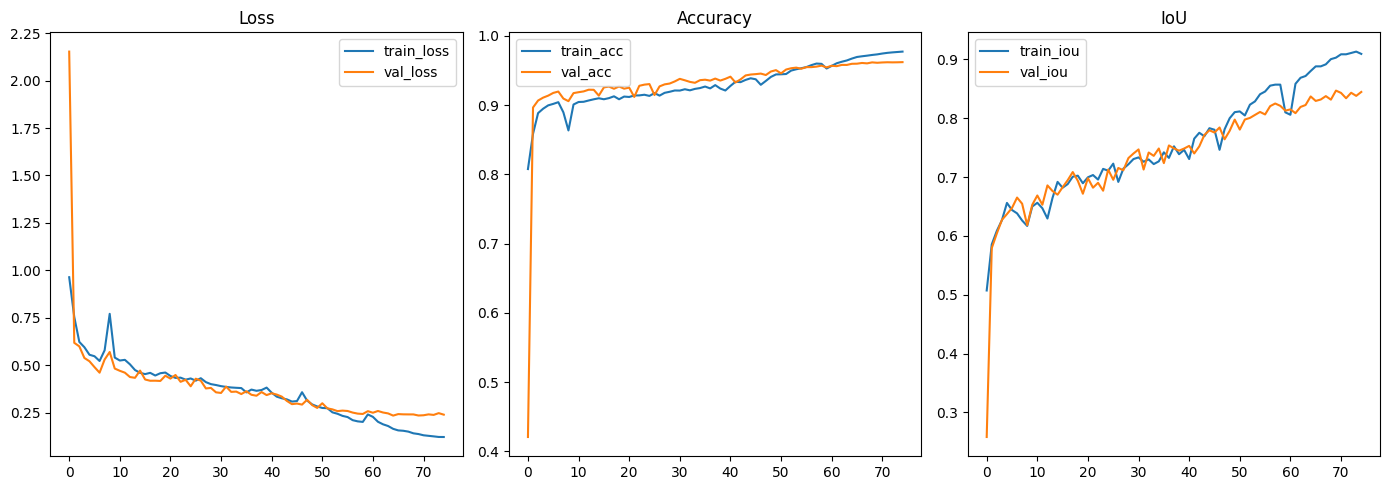

In [ ]:
if 'history' in globals() and hasattr(history, 'history'):
    h = history.history
    plt.figure(figsize=(14,5))
    # Loss
    plt.subplot(1,3,1)
    plt.plot(h.get('loss', []), label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.title('Loss')
    plt.legend()
    # Accuracy
    plt.subplot(1,3,2)
    if 'accuracy' in h or 'acc' in h:
        acc_key = 'accuracy' if 'accuracy' in h else 'acc'
        plt.plot(h.get(acc_key, []), label='train_acc')
        plt.plot(h.get('val_'+acc_key, []), label='val_acc')
        plt.title('Accuracy')
        plt.legend()
    else:
        plt.title('Accuracy not found in history')
    # IoU
    plt.subplot(1,3,3)
    # Metric name might be 'iou_metric' or similar in history
    iou_keys = [k for k in h.keys() if 'iou' in k.lower()]
    if len(iou_keys) >= 1:
        key = iou_keys[0]
        val_key = 'val_' + key if 'val_' + key in h else None
        plt.plot(h.get(key, []), label='train_iou')
        if val_key:
            plt.plot(h.get(val_key, []), label='val_iou')
        plt.title('IoU')
        plt.legend()
    else:
        plt.title('IoU not found in history')
    plt.tight_layout()
    plt.show()
else:
    print("No history object found to plot training curves.")

In [61]:
test_gen = val_gen
results = model.evaluate(test_gen, verbose=1)
print("Evaluate results (loss, accuracy, iou):", results)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step - accuracy: 0.9614 - iou_metric: 0.8295 - loss: 0.2320
Evaluate results (loss, accuracy, iou): [0.23245014250278473, 0.9596518278121948, 0.8428499698638916]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


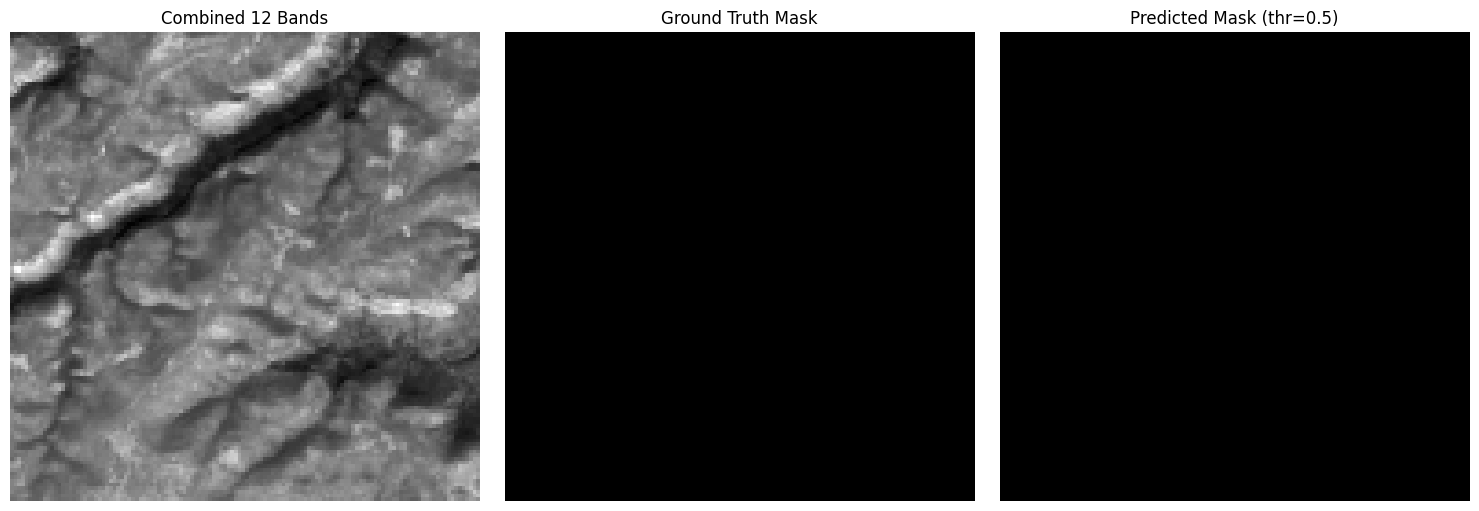

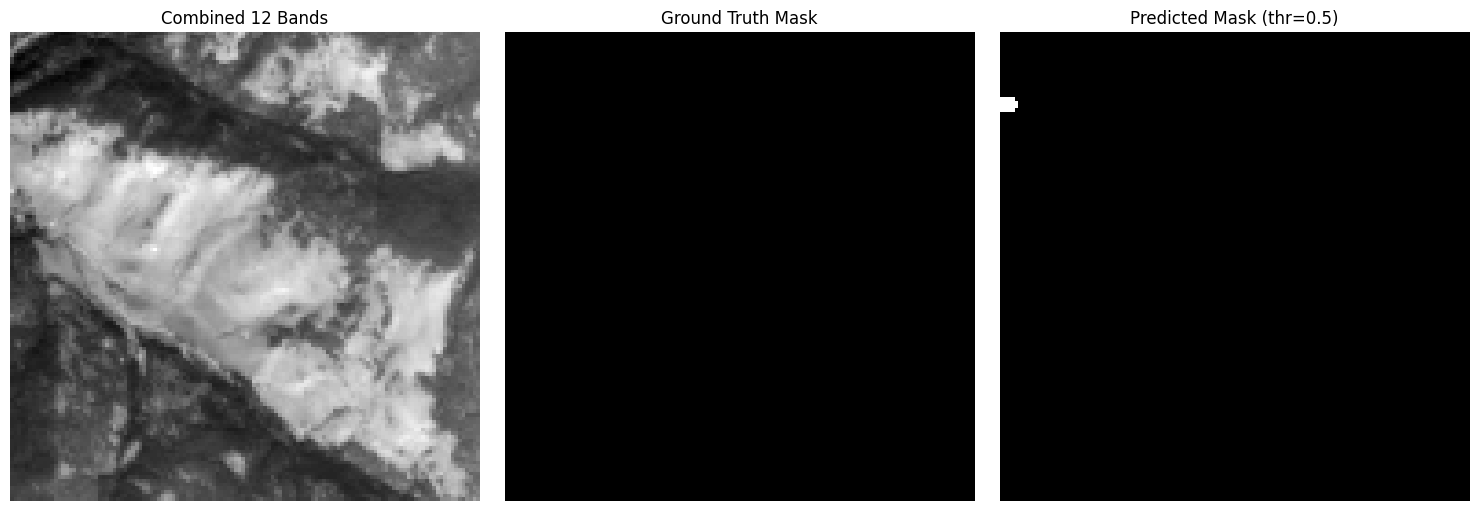

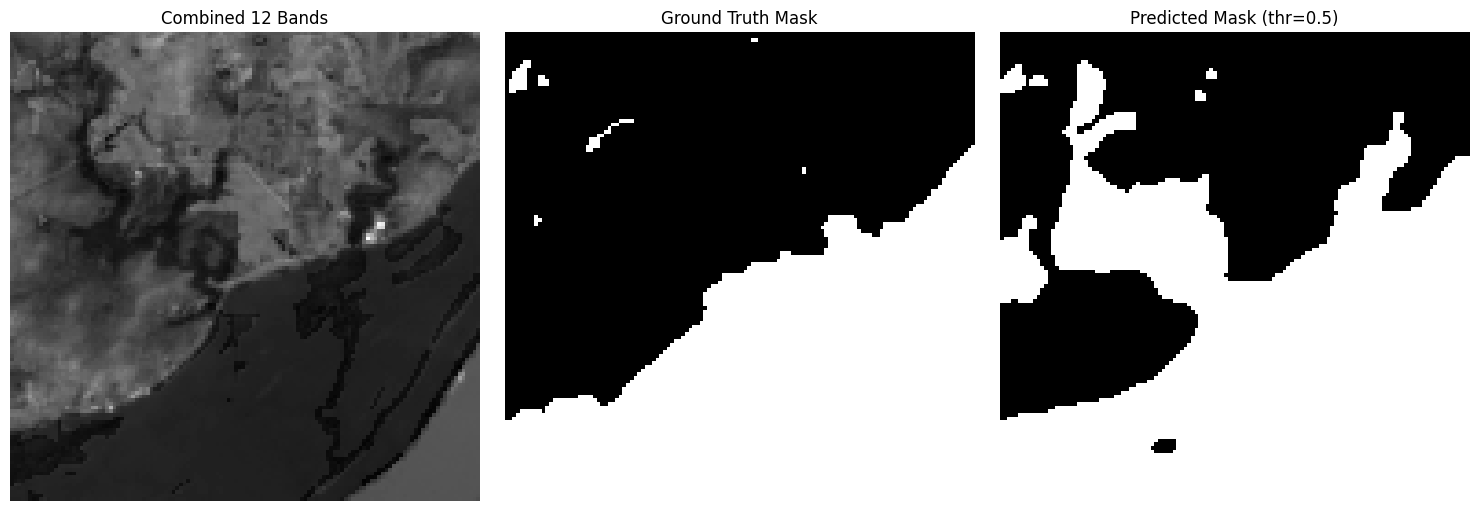

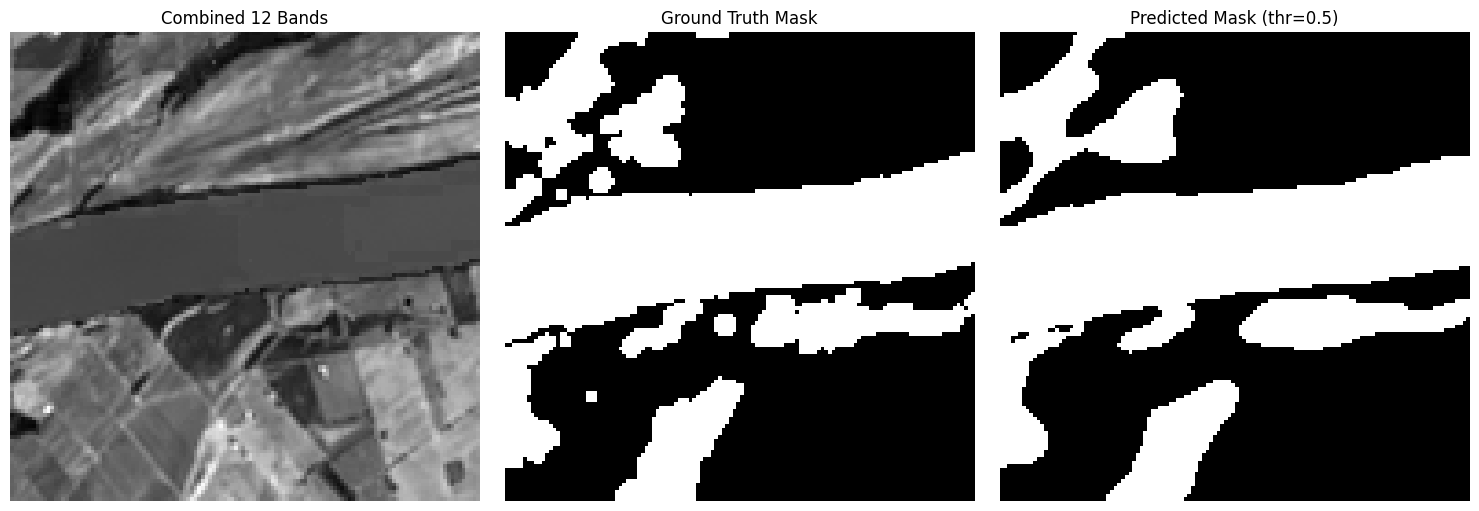

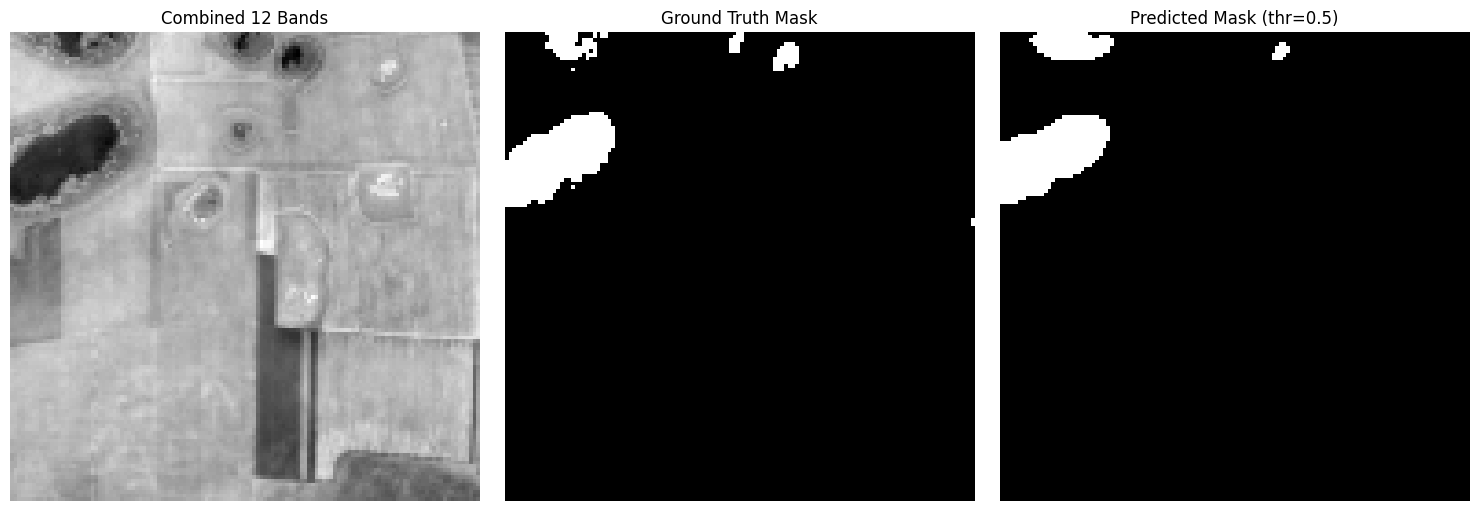

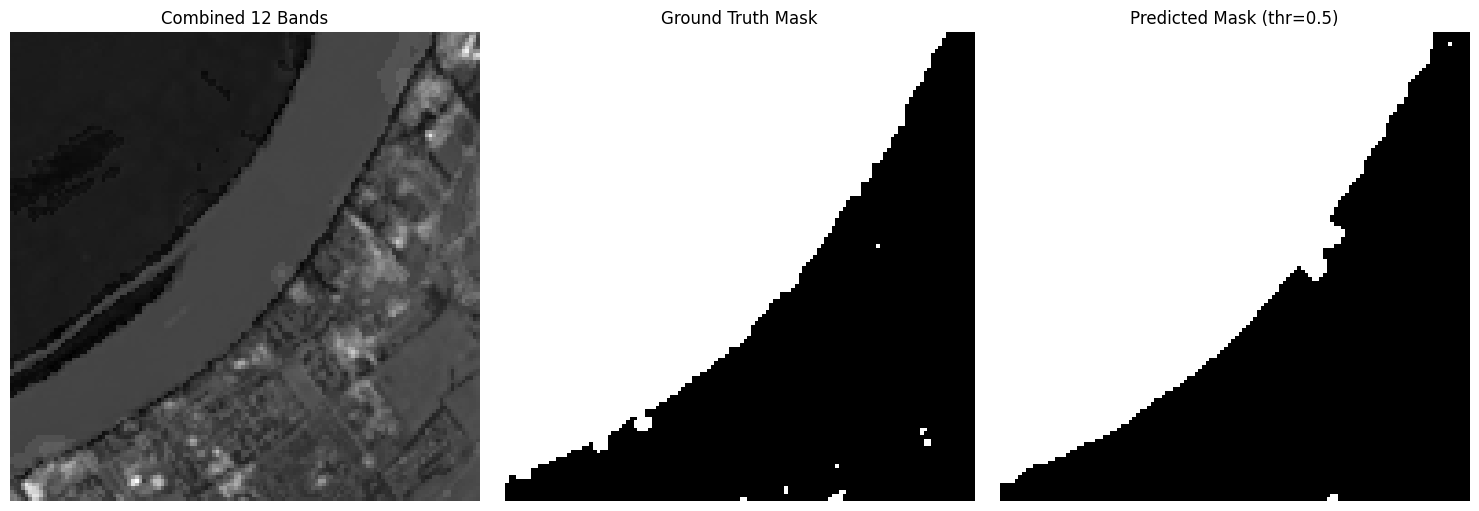

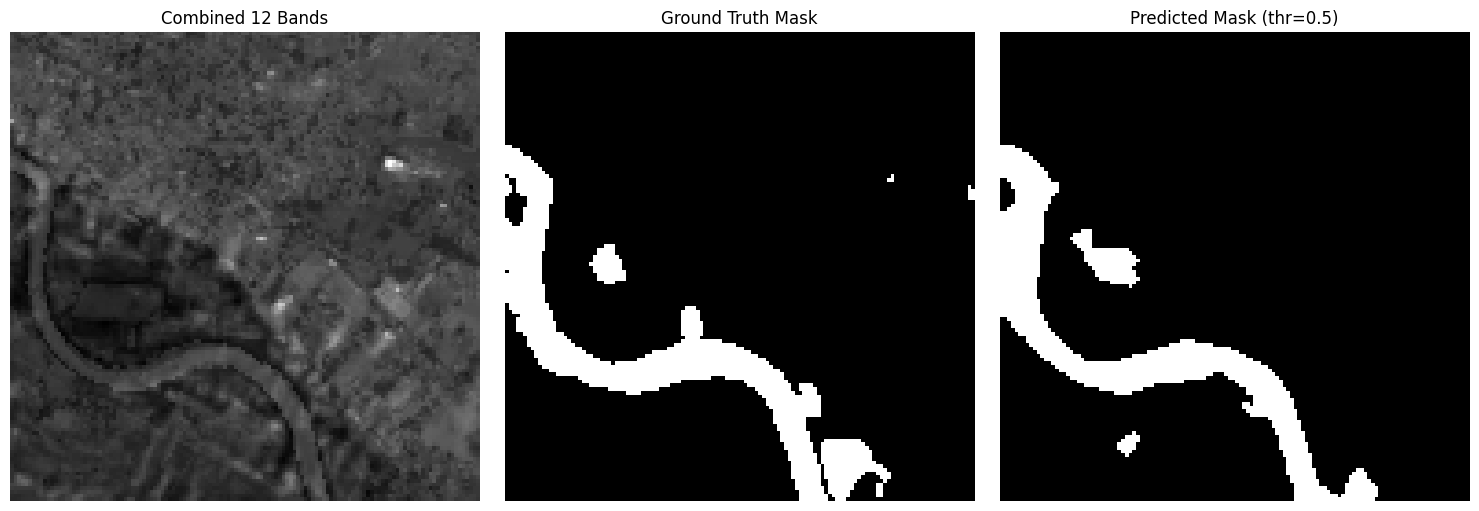

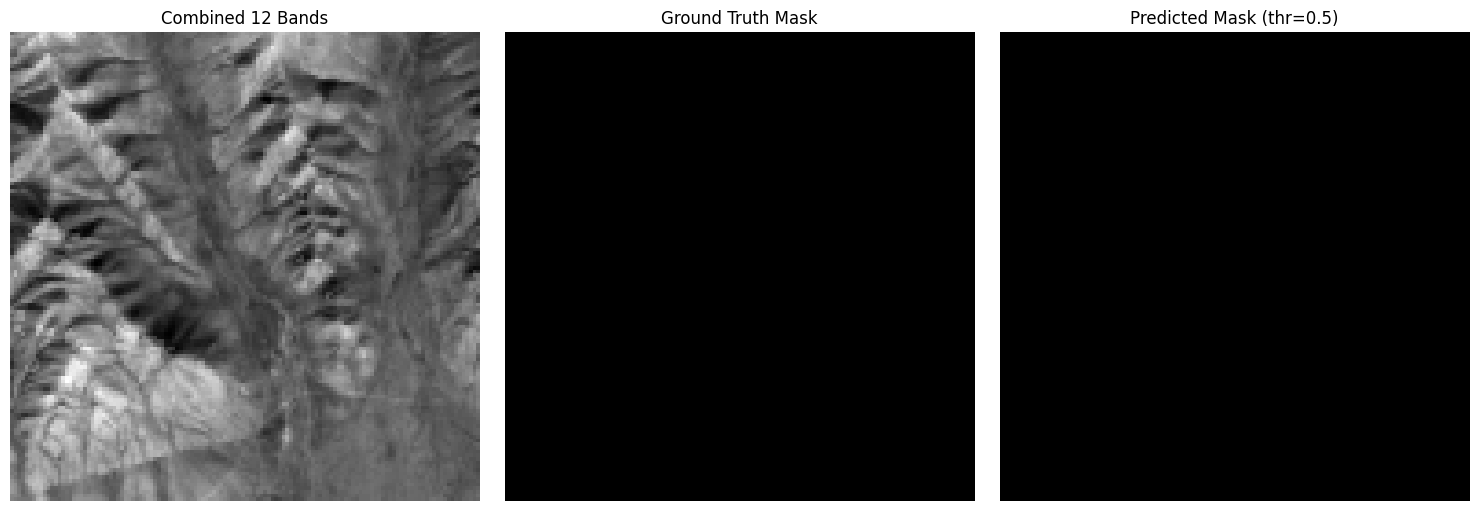

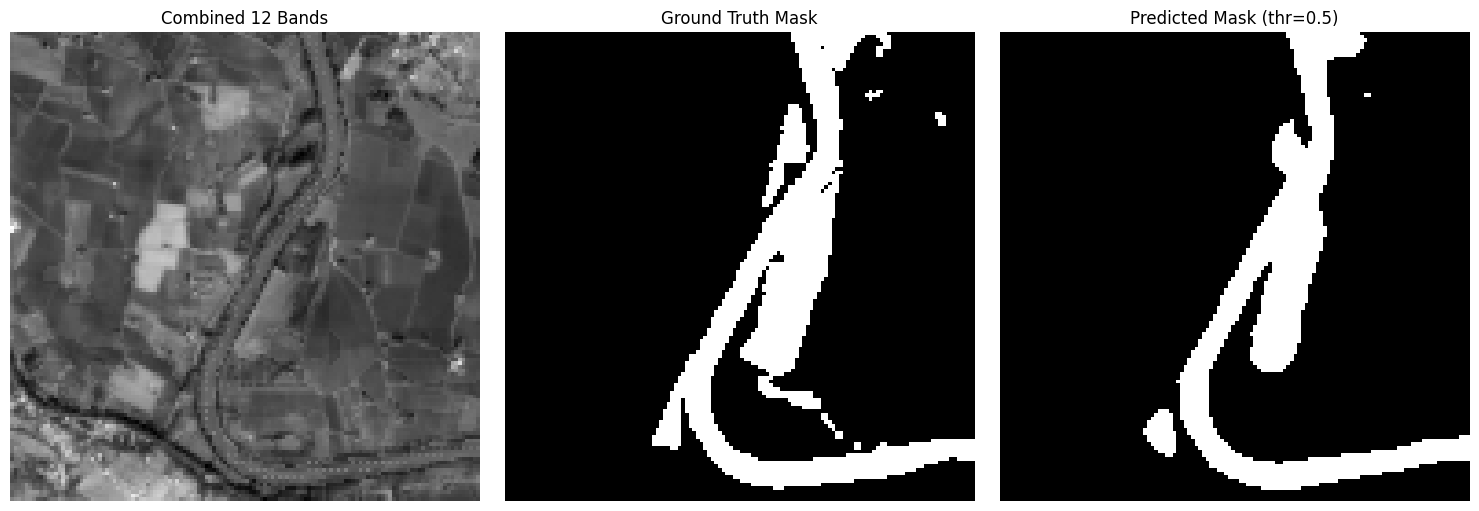

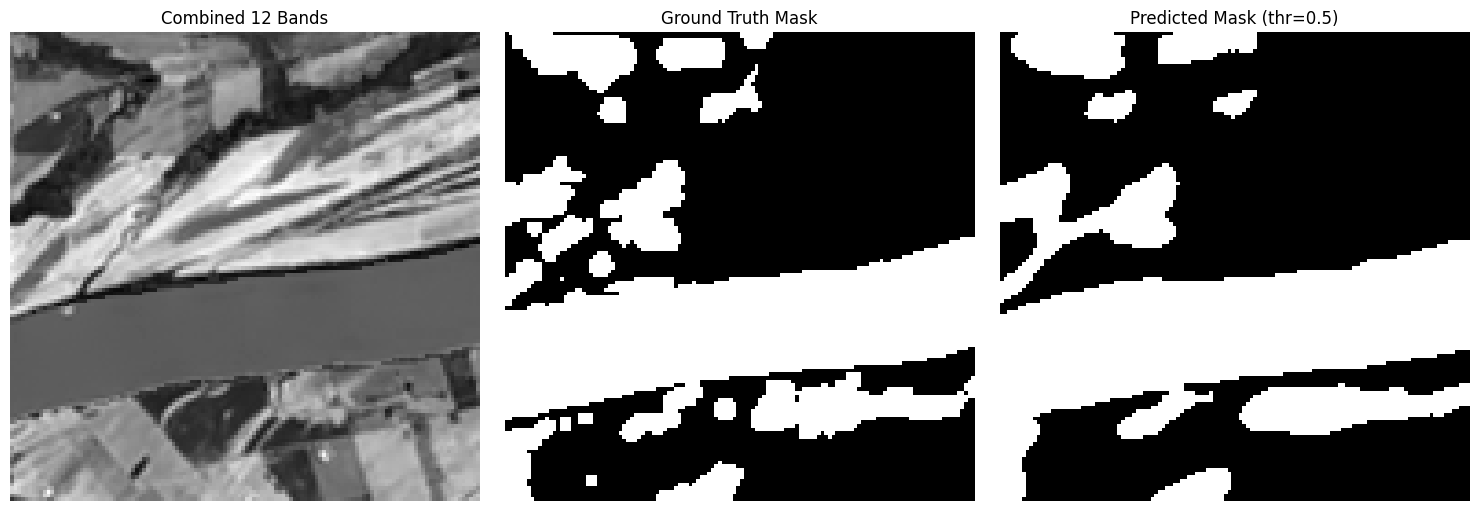

Saved predictions to: predictions


In [ ]:
from matplotlib.image import imsave

def visualize_prediction_combined(gen, model, n_samples=3, out_dir="predictions", threshold=0.5):
    os.makedirs(out_dir, exist_ok=True)
    samples_shown = 0

    for batch_idx in range(len(gen)):
        X_batch, y_batch = gen[batch_idx]
        preds = model.predict(X_batch)

        for i in range(X_batch.shape[0]):
            if samples_shown >= n_samples:
                break

            x = X_batch[i]        # (H, W, 12)
            y_true = y_batch[i, ..., 0]
            y_pred = preds[i, ..., 0]
            y_pred_bin = (y_pred >= threshold).astype(np.uint8)

            # Combine the 12 bands into a single image by averaging
            combined_img = np.mean(x, axis=-1)  # H x W, values 0-1
            combined_img = np.clip(combined_img, 0, 1)

            # Plot them side by side
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(combined_img, cmap='gray')
            axes[0].set_title("Combined 12 Bands")
            axes[0].axis('off')

            axes[1].imshow(y_true, cmap='gray')
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            axes[2].imshow(y_pred_bin, cmap='gray')
            axes[2].set_title(f"Predicted Mask (thr={threshold})")
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            # Save the prediction
            save_path = os.path.join(out_dir, f"pred_batch{batch_idx}_sample{i}.png")
            imsave(save_path, (y_pred_bin * 255).astype(np.uint8))

            samples_shown += 1

        if samples_shown >= n_samples:
            break

    print(f"Saved predictions to: {out_dir}")

# Use the function
# Update the function to display 10 images
visualize_prediction_combined(test_gen, model, n_samples=10, out_dir="predictions", threshold=0.5)



In [ ]:
from google.colab import files

files.download("best_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>